<a href="https://colab.research.google.com/github/philipp-lampert/mymandible/blob/main/data_science/05_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Model training

In [ ]:
import numpy as np
import pandas as pd

We first define a function that imports the prepared CCA and imputed datasets and splits them into train and test sets.

In [ ]:
def cca_imp_train_test_splits(outcome, min_follow_up_days):

  from sklearn.model_selection import train_test_split

  random_state=100
  test_size=0.25

  df_cca = pd.read_parquet('https://github.com/philipp-lampert/mymandible/blob/main/data_science/data/dropped_first_cca.parquet?raw=true')
  df_imp = pd.read_parquet('https://github.com/philipp-lampert/mymandible/blob/main/data_science/data/dropped_first_imputed.parquet?raw=true')

  first_outcome_var = df_cca.columns.get_loc('flap_revision')
  predictors = df_cca.columns[:first_outcome_var].tolist()

  for i, df in enumerate([df_cca, df_imp]):
    dfx = df[df['days_to_follow_up'] >= min_follow_up_days].copy()
    dfx['days_to_flap_loss'] = dfx['days_to_flap_loss'].fillna(10000)
    dfx = dfx[dfx['days_to_flap_loss'] >= min_follow_up_days]
    dfx = dfx.drop('days_to_flap_loss', axis=1)
    dfx = dfx[predictors + [outcome]].dropna()
    if i == 0:
        df_cca = dfx
    else:
        df_imp = dfx

  x_train_cca, x_test_cca, y_train_cca, y_test_cca = train_test_split(df_cca[predictors], df_cca[outcome].astype('int').values,
                                                                      test_size=test_size, random_state=random_state)

  x_train_imp, x_test_imp, y_train_imp, y_test_imp = train_test_split(df_imp[predictors], df_imp[outcome].astype('int').values,
                                                                      test_size=test_size, random_state=random_state)

  return x_train_cca, x_test_cca, y_train_cca, y_test_cca, x_train_imp, x_test_imp, y_train_imp, y_test_imp


Next, we write a function that calculates all performance metrics.

In [ ]:
def metrics(predictions, y_test):

    from sklearn.metrics import matthews_corrcoef, accuracy_score, brier_score_loss, log_loss, f1_score, confusion_matrix, precision_recall_curve, auc
    import matplotlib.pyplot as plt

    thresholds = np.arange(0.45, 0.55, 0.05)
    best_f1 = 0

    for threshold in thresholds:
        predicted_labels = (predictions >= threshold).astype(int)
        f1 = f1_score(y_test, predicted_labels)
        if f1 > best_f1:
            best_predicted_labels = predicted_labels
            best_f1 = f1
            optimal_threshold = threshold

    tn, fp, fn, tp = confusion_matrix(y_test, predicted_labels).ravel()
    precision, recall, thresholds = precision_recall_curve(y_test, predictions)

    print('F1 Score:', best_f1)
    print('AUC PR:', auc(recall, precision))
    print('Accuracy:', accuracy_score(y_test, best_predicted_labels))
    print('Brier Score:', brier_score_loss(y_test, predictions))
    print('Log Loss:', log_loss(y_test, predictions))
    print('\n')
    print('Decision threshold:', optimal_threshold)
    print('TP:', tp)
    print('FP:', fp)
    print('TN:', tn)
    print('FN:', fn)
    plt.plot(recall, precision)
    plt.show()
    print('-----------------------------------------')

##Logistic Regression

In [ ]:
def logistic_regression(outcome, min_follow_up_days, max_iter, cv):

  from sklearn.linear_model import LogisticRegressionCV
  random_state=0

  x_train_cca, x_test_cca, y_train_cca, y_test_cca, x_train_imp, x_test_imp, y_train_imp, y_test_imp = cca_imp_train_test_splits(outcome, min_follow_up_days)

  lrcv = LogisticRegressionCV(solver='newton-cholesky', random_state=random_state, max_iter=max_iter, cv=cv)

  lrcv_cca = lrcv.fit(x_train_cca, y_train_cca)
  predictions_cca = lrcv_cca.predict_proba(x_test_cca)[:, 1]

  lrcv_imp = lrcv.fit(x_train_imp, y_train_imp)
  predictions_imp = lrcv_imp.predict_proba(x_test_imp)[:, 1]

  print("Complete Case Analysis:")
  metrics(predictions_cca, y_test_cca)
  print("Imputed Data:")
  metrics(predictions_imp, y_test_imp)

Complete Case Analysis:
F1 Score: 0.5555555555555556
AUC PR: 0.5765547640287344
Accuracy: 0.5675675675675675
Brier Score: 0.3087910416144906
Log Loss: 1.038438446458899


Decision threshold: 0.45
TP: 9
FP: 6
TN: 13
FN: 9


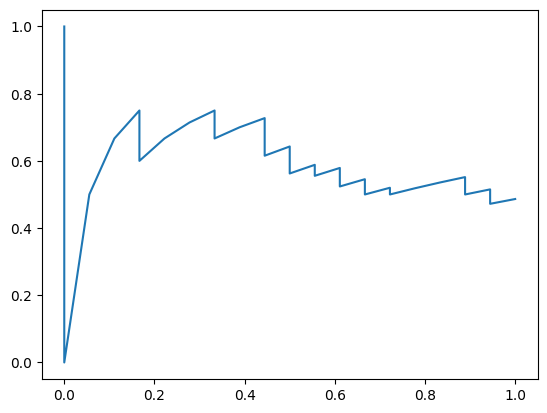

-----------------------------------------
Imputed Data:
F1 Score: 0.5142857142857142
AUC PR: 0.4648367189250856
Accuracy: 0.5641025641025641
Brier Score: 0.39837362621815287
Log Loss: 1.833497391796643


Decision threshold: 0.55
TP: 9
FP: 7
TN: 13
FN: 10


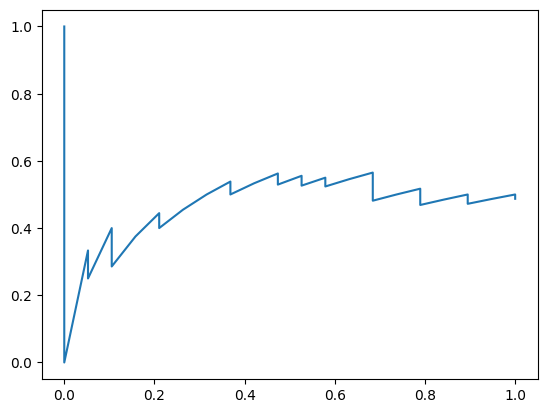

-----------------------------------------


In [ ]:
logistic_regression('soft_tissue_complication', min_follow_up_days=30, max_iter=1000, cv=5)

##kNN Classifier

In [ ]:
def knn(outcome, min_follow_up_days, neighbors):

  from sklearn.neighbors import KNeighborsClassifier

  x_train_cca, x_test_cca, y_train_cca, y_test_cca, x_train_imp, x_test_imp, y_train_imp, y_test_imp = cca_imp_train_test_splits(outcome, min_follow_up_days)

  knn = KNeighborsClassifier(n_neighbors=neighbors, weights='distance')

  knn_cca = knn.fit(x_train_cca, y_train_cca)
  predictions_cca = knn_cca.predict_proba(x_test_cca)[:, 1]

  knn_imp = knn.fit(x_train_imp, y_train_imp)
  predictions_imp = knn_imp.predict_proba(x_test_imp)[:, 1]

  print("Complete Case Analysis:")
  metrics(predictions_cca, y_test_cca)
  print("Imputed Data:")
  metrics(predictions_imp, y_test_imp)

Complete Case Analysis:
F1 Score: 0.5555555555555556
AUC PR: 0.5838893513023893
Accuracy: 0.5675675675675675
Brier Score: 0.2722927770531333
Log Loss: 1.6519297432831843


Decision threshold: 0.45
TP: 8
FP: 7
TN: 12
FN: 10


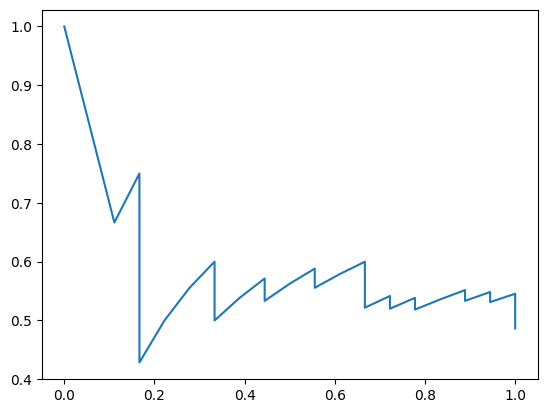

-----------------------------------------
Imputed Data:
F1 Score: 0.5853658536585366
AUC PR: 0.5339039456614963
Accuracy: 0.5641025641025641
Brier Score: 0.3101073019089009
Log Loss: 2.5710865575799544


Decision threshold: 0.55
TP: 12
FP: 10
TN: 10
FN: 7


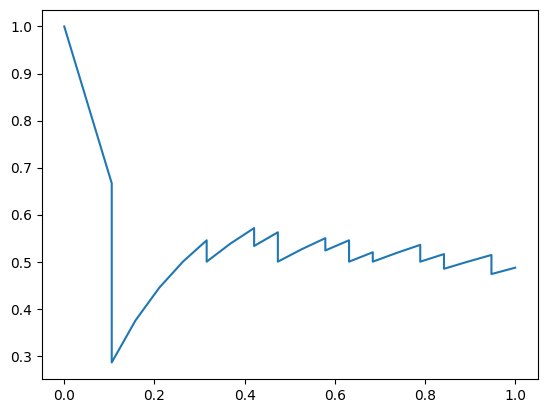

-----------------------------------------


In [ ]:
knn('soft_tissue_complication', min_follow_up_days=30, neighbors=5)

##Random Forest

In [ ]:
def random_forest(outcome, min_follow_up_days, n_estimators, max_depth):
  from sklearn.ensemble import RandomForestClassifier

  random_state=0

  x_train_cca, x_test_cca, y_train_cca, y_test_cca, x_train_imp, x_test_imp, y_train_imp, y_test_imp = cca_imp_train_test_splits(outcome, min_follow_up_days)

  rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)

  rf_cca = rf.fit(x_train_cca, y_train_cca)
  predictions_cca = rf_cca.predict_proba(x_test_cca)[:, 1]

  rf_imp = rf.fit(x_train_imp, y_train_imp)
  predictions_imp = rf_imp.predict_proba(x_test_imp)[:, 1]

  print("Complete Case Analysis:")
  metrics(predictions_cca, y_test_cca)
  print("Imputed Data:")
  metrics(predictions_imp, y_test_imp)


Complete Case Analysis:
F1 Score: 0.631578947368421
AUC PR: 0.6931396576416939
Accuracy: 0.6216216216216216
Brier Score: 0.23173179055863463
Log Loss: 0.655850346753721


Decision threshold: 0.5
TP: 10
FP: 5
TN: 14
FN: 8


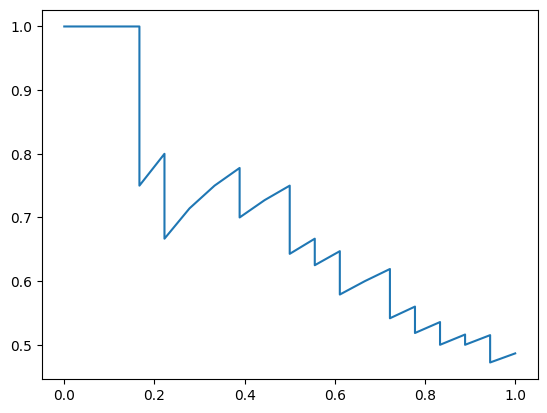

-----------------------------------------
Imputed Data:
F1 Score: 0.653061224489796
AUC PR: 0.6022556311169667
Accuracy: 0.5641025641025641
Brier Score: 0.23522571832023645
Log Loss: 0.6632999646151425


Decision threshold: 0.45
TP: 9
FP: 6
TN: 14
FN: 10


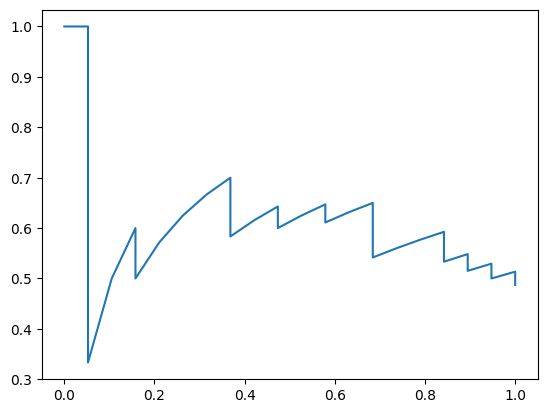

-----------------------------------------


In [ ]:
random_forest('soft_tissue_complication', min_follow_up_days=30, n_estimators=100, max_depth=3)